## Artigo 2

A proposta desse notebook é dar continuidade ao Artigo 1 explorando agora problemas não linearmente separáveis. A ideia principal é executar e comparar 3 abordagens diferentes. Vamos usar um naive bayes com KDE para classificação e seleção de instâncias para o grafo de gabriel, assim como comparar o grafo completo com o reduzido.


### Proposta de classificador Bayesiano para duas classes.

Veja que:

$$P(C_i|X) = \frac{P(X|C_i)\times P(C_i)}{P(X)}$$

$$P(C_i|X) \propto P(X|C_i)\times P(C_i)$$

Estimar $P(X)$ é desnecessário visto que estamos interessados na razão das duas probabilidades

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gg
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
import time

## Classificador Não linear

In [2]:

def classify_by_nearest_support(graph, new_points):
    """
    Para cada ponto em `new_points`, atribui a classe do vértice de suporte
    mais próximo no grafo de Gabriel `graph`.
    """
    if graph.X is None or graph.y is None:
        raise RuntimeError("Construa o grafo com X e y antes de usar esta função.")

    # índices dos vértices que participam de arestas de suporte (classes opostas conectadas)
    support_indices = {idx for edge in graph.support_edges() for idx in edge}
    if not support_indices:
        raise RuntimeError("Nenhum vértice de suporte disponível no grafo.")

    support_indices = np.array(sorted(support_indices), dtype=int)
    support_points = graph.X.detach().cpu().numpy()[support_indices]
    support_labels = graph.y.detach().cpu().numpy()[support_indices]

    new_points = np.asarray(new_points, dtype=float)
    if new_points.ndim == 1:
        new_points = new_points[None, :]

    # distâncias quadráticas para todos os vértices de suporte
    diff = new_points[:, None, :] - support_points[None, :, :]
    dist2 = np.sum(diff ** 2, axis=2)

    # pega o índice do suporte mais próximo para cada novo ponto
    nearest = np.argmin(dist2, axis=1)
    return support_labels[nearest]

def local_hyperplane_classifier(p, planes, sigma=1.0):
    """
    p: (d,)
    planes: lista de (mid, normal) já orientados (lado positivo => classe +1)
    """
    if not planes:
        return 0
    p = np.asarray(p, float)
    votes = []
    weights = []
    for mid, normal in planes:
        mid = np.asarray(mid)
        normal = np.asarray(normal)
        raw = (p - mid) @ normal
        # voto: sinal direto (porque normal já orientada)
        vote = 1 if raw >= 0 else -1
        # distância ao plano (margem geométrica)
        margin = np.linalg.norm(p-mid)
        # peso: gaussiano inverso (maior peso se p mais próximo do plano)
        w = np.exp(- (margin**2) / (2 * sigma**2))
        votes.append(vote)
        weights.append(w)
    weights = np.array(weights)
    if weights.sum() == 0:
        weights = np.ones_like(weights)
    weights /= weights.sum()
    score = np.dot(weights, votes)
    return 1 if score >= 0 else -1

def build_oriented_hyperplanes(G):
    planes = []
    # Assume G.X (n,d) e G.y (n,) em {-1,+1}
    for (i, j) in G.support_edges():
        yi, yj = G.y[i], G.y[j]
        if yi == yj:
            continue  # só interessa separar classes distintas
        mid = (G.X[i] + G.X[j]) / 2.0
        normal = G.X[j] - G.X[i]  # vetor i -> j
        # Orienta normal para que lado positivo seja classe +1
        # Queremos (p-mid)·normal > 0 => predição +1
        # Se o ponto j for -1 e i for +1, inverte:
        if yj == -1 and yi == 1:
            normal = -normal
        # Se (yi,yj)=(-1,+1) fica como está; se (+1,-1) foi invertido.
        planes.append((mid, normal))
    return planes

## Definição do KNB

In [3]:
# Classificador Bayesiano com KDE (Kernel Density Estimation)
from sklearn.neighbors import KernelDensity

def _logsumexp(a, axis=0):
    a = np.asarray(a)
    a_max = np.max(a, axis=axis, keepdims=True)
    stable = a - a_max
    sum_exp = np.exp(stable).sum(axis=axis, keepdims=True)
    return (a_max + np.log(sum_exp)).squeeze(axis)

class KernelDensityNaiveBayes:
    def __init__(self, bandwidth=0.3, kernel="gaussian"):
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.classes_ = None
        self.models_ = None
        self.log_prior_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        classes, counts = np.unique(y, return_counts=True)
        self.classes_ = classes
        self.log_prior_ = np.log(counts / counts.sum())
        self.models_ = []
        for cls in classes:
            kde = KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel)
            kde.fit(X[y == cls])
            self.models_.append(kde)
        return self

    def _joint_log_likelihood(self, X):
        X = np.asarray(X)
        if self.models_ is None:
            raise RuntimeError("O modelo precisa ser ajustado antes de prever.")
        log_likelihood = []
        for log_prior, kde in zip(self.log_prior_, self.models_):
            log_likelihood.append(log_prior + kde.score_samples(X))
        return np.vstack(log_likelihood).T

    def predict_log_proba(self, X):
        jll = self._joint_log_likelihood(X)
        log_prob_norm = _logsumexp(jll, axis=1)
        return jll - log_prob_norm[:, None]

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        indices = np.argmax(jll, axis=1)
        return self.classes_[indices]

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

        


## Data-Sets 2D

In [4]:
def make_spirals(n_points=1000, noise=0.15, rng=None):
    """Gera um dataset de duas espirais entrelaçadas com ruído controlado."""
    rng = np.random.default_rng() if rng is None else rng
    n = n_points // 2
    theta0 = np.sqrt(rng.random(n)) * 2.5 * np.pi  # Ângulo
    r0 = theta0 + 1.5  # Raio
    x0 = (r0 + rng.normal(0.0, noise, n)) * np.cos(theta0)
    y0 = (r0 + rng.normal(0.0, noise, n)) * np.sin(theta0)
    theta1 = np.sqrt(rng.random(n)) * 2.5 * np.pi
    r1 = theta1 + 1.5
    x1 = (r1 + rng.normal(0.0, noise, n)) * np.cos(theta1 + np.pi)
    y1 = (r1 + rng.normal(0.0, noise, n)) * np.sin(theta1 + np.pi)
    X = np.vstack((np.column_stack((x0, y0)), np.column_stack((x1, y1))))
    y = np.hstack((-1 * np.ones(n), np.ones(n)))
    return X, y

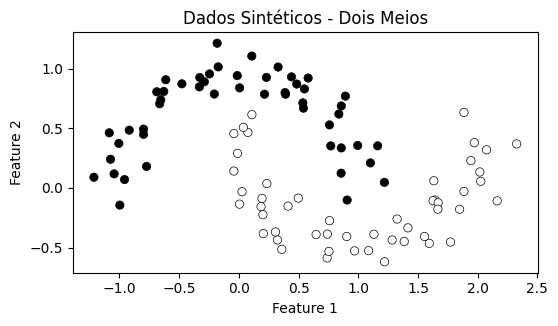

In [5]:


# Configuração global para plots em tons de cinza
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["0.15", "0.7"])

# Geração de dados sintéticos linearmente não separáveis
# Meia Luas
X, y = datasets.make_moons(n_samples=100, noise=0.12, random_state=42)
y[y == 0] = -1

# Plot dos dados em escala de cinza
fig, ax = plt.subplots()
shades = ((y + 1) // 2).astype(int)
ax.scatter(X[:, 0], X[:, 1], c=shades, cmap="gray", vmin=0, vmax=1, edgecolors="black", linewidths=0.5)
ax.set_title("Dados Sintéticos - Dois Meios")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_aspect("equal")
plt.show()

## Experimentos

In [9]:
import json
import pandas as pd

selection_fraction = 0.3
sample_sizes = [100, 500, 1000,2000,5000,10000]
dataset_names = ["make_moons", "make_spirals", "make_circles"]
rng = np.random.default_rng(42)

def _generate_dataset(name, n, seed):
    if name == "make_moons":
        X, y = datasets.make_moons(n_samples=n, noise=0.15, random_state=seed)
    elif name == "make_spirals":
        X, y = make_spirals(n_points=n, noise=0.15, rng=np.random.default_rng(seed))
    elif name == "make_circles":
        X, y = datasets.make_circles(n_samples=n, noise=0.07, factor=0.5, random_state=seed)
    else:
        raise ValueError(f"Dataset desconhecido: {name}")
    y = y.copy()
    y[y == 0] = -1
    return X, y

def _support_coverage(graph_full, selected_indices):
    support_vertices = set(graph_full.support_vertex_indices())
    if not support_vertices:
        return {
            "support_vertex_count": 0,
            "covered_support_vertices": 0,
            "coverage_pct": None,
        }
    selected = set(int(idx) for idx in selected_indices)
    covered = support_vertices & selected
    coverage = 100.0 * len(covered) / len(support_vertices)
    return {
        "support_vertex_count": len(support_vertices),
        "covered_support_vertices": len(covered),
        "coverage_pct": coverage,
    }

rows = []
coverage_rows = []

for n in sample_sizes:
    for name in dataset_names:
        seed = int(rng.integers(0, 10_000))
        X, y = _generate_dataset(name, n, seed)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        G_full = gg.GabrielGraph(device="cpu")
        start = time.time()
        G_full.build(X_train, y_train)
        build_time_full = time.time() - start
        y_pred_full = classify_by_nearest_support(G_full, X_test)
        acc_full = float(np.mean(y_pred_full == y_test))

        start = time.time()
        kde_nb = KernelDensityNaiveBayes(bandwidth=0.3)
        kde_nb.fit(X_train, y_train)
        build_time_kde = time.time() - start
        y_pred_kde = kde_nb.predict(X_test)
        acc_kde = float(np.mean(y_pred_kde == y_test))

        log_probas = kde_nb.predict_log_proba(X_train)
        uncertainty = np.abs(log_probas[:, 1] - log_probas[:, 0])
        k = max(1, int(np.ceil(selection_fraction * len(X_train))))
        selected_idx = np.argsort(uncertainty)[:k]
        X_sel = X_train[selected_idx]
        y_sel = y_train[selected_idx]

        G_reduced = gg.GabrielGraph(device="cpu")
        start = time.time()
        G_reduced.build(X_sel, y_sel)
        build_time_reduced = time.time() - start
        y_pred_reduced = classify_by_nearest_support(G_reduced, X_test)
        acc_reduced = float(np.mean(y_pred_reduced == y_test))

        coverage_info = _support_coverage(G_full, selected_idx)
        coverage_rows.append({
            "dataset": name,
            "n": int(n),
            "support_vertex_count": int(coverage_info["support_vertex_count"]),
            "covered_support_vertices": int(coverage_info["covered_support_vertices"]),
            "coverage_pct": None if coverage_info["coverage_pct"] is None else float(coverage_info["coverage_pct"]),
            "selected_samples": int(len(selected_idx)),
        })

        rows.extend([
            {
                "dataset": name,
                "n": int(n),
                "method": "gabriel_full",
                "build_time": float(build_time_full),
                "accuracy": acc_full,
                
            },
            {
                "dataset": name,
                "n": int(n),
                "method": "kde_naive_bayes",
                "build_time": float(build_time_kde),
                "accuracy": acc_kde,
                
            },
            {
                "dataset": name,
                "n": int(n),
                "method": "gabriel_uncertain",
                "build_time": float(build_time_reduced),
                "accuracy": acc_reduced,
                "selected_samples": int(len(selected_idx)),
            },
        ])

results_df = pd.DataFrame(rows)
coverage_df = pd.DataFrame(coverage_rows)

accuracy_table = (
    results_df
    .pivot_table(index=["dataset", "n"], columns="method", values="accuracy", aggfunc="first")
    .reset_index()
    .sort_values(["dataset", "n"])
)
accuracy_table.columns.name = None

display(accuracy_table)

with open("resultados_tempos_acuracias.json", "w", encoding="utf-8") as fp:
    json.dump(results_df.to_dict(orient="records"), fp, ensure_ascii=False, indent=2)

coverage_df_sorted = coverage_df.sort_values(["dataset", "n"]).reset_index(drop=True)
display(coverage_df_sorted)

with open("cobertura_suportes.json", "w", encoding="utf-8") as fp:
    json.dump(coverage_df_sorted.to_dict(orient="records"), fp, ensure_ascii=False, indent=2)

print("Resultados estruturados foram salvos em resultados_tempos_acuracias.json")
print("Cobertura de vértices de suporte salva em cobertura_suportes.json")

,dataset,n,gabriel_full,gabriel_uncertain,kde_naive_bayes
0,make_circles,100,1.000000,0.966667,1.000000
1,make_circles,500,1.000000,0.946667,1.000000
2,make_circles,1000,1.000000,0.990000,0.996667
3,make_circles,2000,1.000000,0.995000,0.996667
4,make_circles,5000,1.000000,1.000000,0.999333
5,make_circles,10000,0.999667,0.999667,0.996667
6,make_moons,100,0.933333,0.833333,0.966667
7,make_moons,500,0.986667,0.986667,0.980000
8,make_moons,1000,0.980000,0.973333,0.976667
9,make_moons,2000,0.985000,0.985000,0.985000


,dataset,n,support_vertex_count,covered_support_vertices,coverage_pct,selected_samples
0,make_circles,100,38,18,47.368421,21
1,make_circles,500,53,37,69.811321,105
2,make_circles,1000,60,48,80.000000,210
3,make_circles,2000,72,59,81.944444,420
4,make_circles,5000,84,80,95.238095,1050
5,make_circles,10000,98,98,100.000000,2100
6,make_moons,100,22,16,72.727273,21
7,make_moons,500,29,27,93.103448,105
8,make_moons,1000,57,52,91.228070,210
9,make_moons,2000,62,60,96.774194,420


Resultados estruturados foram salvos em resultados_tempos_acuracias.json
Cobertura de vértices de suporte salva em cobertura_suportes.json


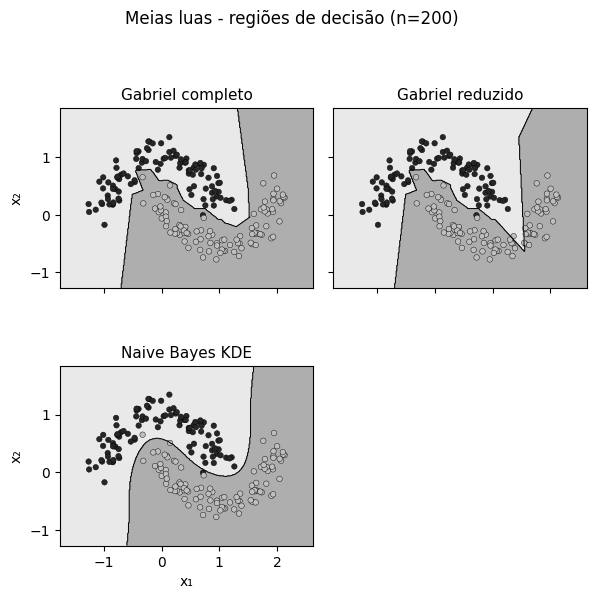

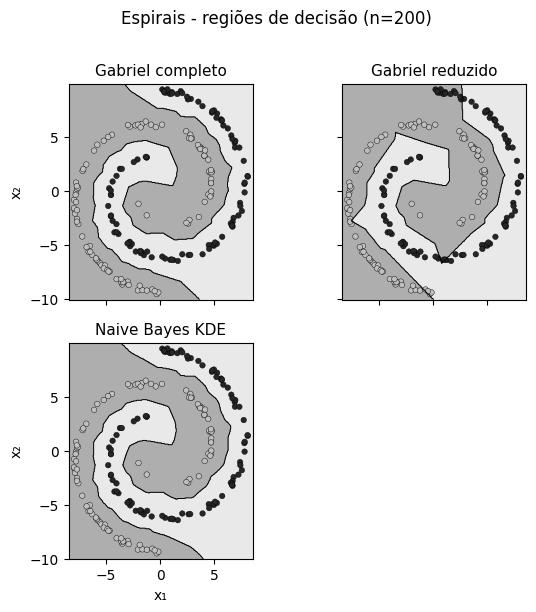

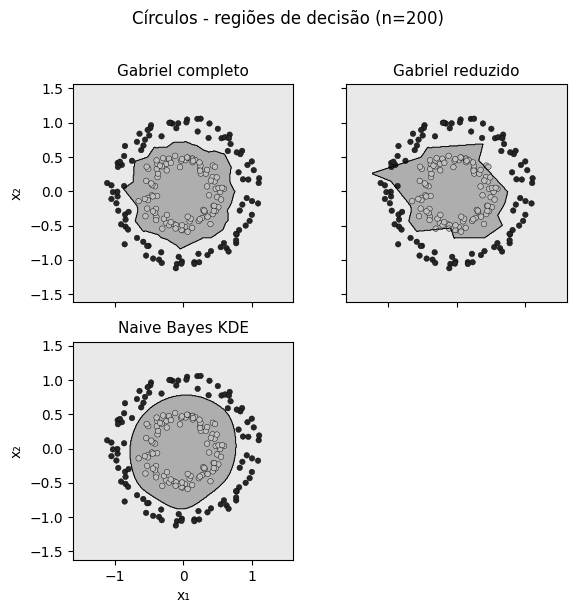

In [ ]:
from matplotlib.colors import ListedColormap
from pathlib import Path

def _predict_graph(graph, points):
    try:
        return classify_by_nearest_support(graph, points)
    except RuntimeError:
        return np.zeros(len(points), dtype=int)

def _plot_decision_regions(graph_full, graph_reduced, kde_model, grid, xx, yy):
    Z_full = _predict_graph(graph_full, grid).reshape(xx.shape)
    Z_reduced = _predict_graph(graph_reduced, grid).reshape(xx.shape)
    Z_kde = kde_model.predict(grid).reshape(xx.shape)
    return Z_full, Z_reduced, Z_kde

_decision_cmap_regions = ListedColormap(["0.88", "0.55"])
_decision_cmap_points = ListedColormap(["0.15", "0.75"])

datasets_for_plots = [
    ("make_moons", "Meias luas"),
    ("make_spirals", "Espirais"),
    ("make_circles", "Círculos"),
]
plot_seed = 2025
sample_size_plot = 200
plot_selection_fraction = 0.3
plot_bandwidth = 0.25
plot_output_dir = Path("figuras_decision_regions")
plot_output_dir.mkdir(exist_ok=True)

for dataset_key, dataset_label in datasets_for_plots:
    X_data, y_data = _generate_dataset(dataset_key, sample_size_plot, plot_seed)
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.4, random_state=42, stratify=y_data
    )

    G_full_plot = gg.GabrielGraph(device="cpu")
    G_full_plot.build(X_train, y_train)

    kde_nb_plot = KernelDensityNaiveBayes(bandwidth=plot_bandwidth)
    kde_nb_plot.fit(X_train, y_train)
    log_probas_plot = kde_nb_plot.predict_log_proba(X_train)
    uncertainty_plot = np.abs(log_probas_plot[:, 1] - log_probas_plot[:, 0])
    k_plot = max(1, int(np.ceil(plot_selection_fraction * len(X_train))))
    selected_indices_plot = np.argsort(uncertainty_plot)[:k_plot]
    X_sel_plot = X_train[selected_indices_plot]
    y_sel_plot = y_train[selected_indices_plot]

    G_reduced_plot = gg.GabrielGraph(device="cpu")
    G_reduced_plot.build(X_sel_plot, y_sel_plot)

    x_min, x_max = X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5
    y_min, y_max = X_data[:, 1].min() - 0.5, X_data[:, 1].max() + 0.5
    xx_plot, yy_plot = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350),
    )
    grid_plot = np.c_[xx_plot.ravel(), yy_plot.ravel()]

    Z_full_plot, Z_reduced_plot, Z_kde_plot = _plot_decision_regions(
        G_full_plot, G_reduced_plot, kde_nb_plot, grid_plot, xx_plot, yy_plot
    )

    fig, ax_grid = plt.subplots(2, 2, figsize=(6.2, 6.2), sharex=True, sharey=True)
    fig.suptitle(f"{dataset_label} - regiões de decisão (n={sample_size_plot})", fontsize=12)
    axes = ax_grid.flatten()
    titles_plot = ("Gabriel completo", "Gabriel reduzido", "Naive Bayes KDE")
    data_colors = ((y_data + 1) // 2).astype(int)
    for ax_plot, Z_plot, title_plot in zip(axes[:3], [Z_full_plot, Z_reduced_plot, Z_kde_plot], titles_plot):
        ax_plot.contourf(
            xx_plot,
            yy_plot,
            Z_plot,
            levels=[-1, 0, 1],
            cmap=_decision_cmap_regions,
            alpha=0.7,
        )
        ax_plot.contour(xx_plot, yy_plot, Z_plot, levels=[0], colors="black", linewidths=0.7)
        ax_plot.scatter(
            X_data[:, 0],
            X_data[:, 1],
            c=data_colors,
            cmap=_decision_cmap_points,
            edgecolors="black",
            linewidths=0.3,
            s=16,
        )
        ax_plot.set_title(title_plot, fontsize=11)
        ax_plot.set_aspect("equal")
    fig.delaxes(axes[-1])
    ax_grid[1, 0].set_xlabel("x₁")
    ax_grid[1, 1].set_xlabel("x₁")
    ax_grid[0, 0].set_ylabel("x₂")
    ax_grid[1, 0].set_ylabel("x₂")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    output_path = plot_output_dir / f"decision_regions_{dataset_key}_{sample_size_plot}.png"
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Figura salva em {output_path}")

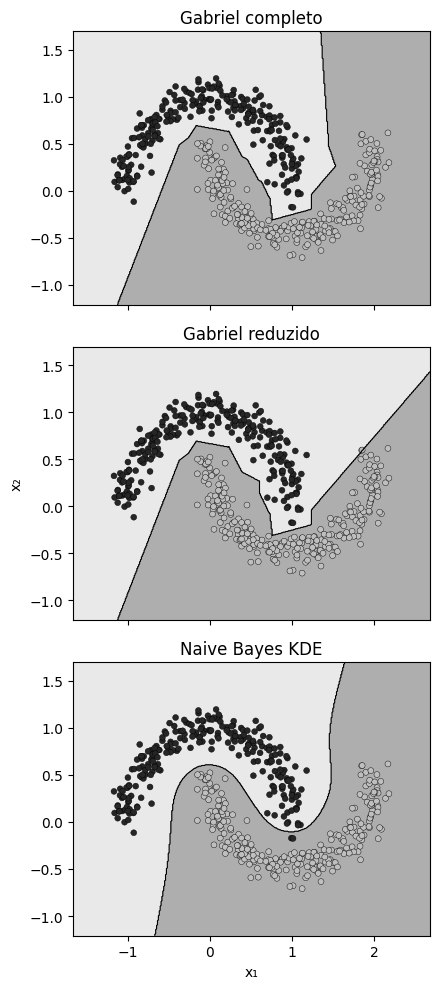

Cobertura dos vértices de suporte: 15 de 18 (83.33%).


In [80]:
#Plotar regiões de decisão usando as 3 abordagens
from matplotlib.colors import ListedColormap

rng_local = np.random.default_rng(7)
X, y = datasets.make_moons(n_samples=500, noise=0.1, random_state=10)
y = y.astype(int)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=42, stratify=y
)

# Grafo completo
G_full = gg.GabrielGraph(device="cpu")
G_full.build(X_train, y_train)

# Classificador KDE para seleção de amostras
kde_nb = KernelDensityNaiveBayes(bandwidth=0.2)
kde_nb.fit(X_train, y_train)
log_probas = kde_nb.predict_log_proba(X_train)
uncertainty = np.abs(log_probas[:, 1] - log_probas[:, 0])
selection_fraction = 0.3
k = max(1, int(np.ceil(selection_fraction * len(X_train))))
selected_indices = np.argsort(uncertainty)[:k]
X_sel = X_train[selected_indices]
y_sel = y_train[selected_indices]

# Grafo reduzido com pontos incertos
G_reduced = gg.GabrielGraph(device="cpu")
G_reduced.build(X_sel, y_sel)

# Grade para fronteiras de decisão
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400),
)
grid = np.c_[xx.ravel(), yy.ravel()]

def _predict_graph(graph, points):
    try:
        return classify_by_nearest_support(graph, points)
    except RuntimeError:
        return np.zeros(len(points), dtype=int)

Z_full = _predict_graph(G_full, grid).reshape(xx.shape)
Z_reduced = _predict_graph(G_reduced, grid).reshape(xx.shape)
Z_kde = kde_nb.predict(grid).reshape(xx.shape)

cmap_regions = ListedColormap(["0.88", "0.55"])
cmap_points = ListedColormap(["0.15", "0.75"])
point_colors = ((y + 1) // 2).astype(int)

fig, axes = plt.subplots(3, 1, figsize=(4.5, 10), sharex=True, sharey=True)
titles = (
    "Gabriel completo",
    "Gabriel reduzido",
    "Naive Bayes KDE",
)
for ax, Z, title in zip(axes, [Z_full, Z_reduced, Z_kde], titles):
    ax.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap=cmap_regions, alpha=0.7)
    ax.contour(xx, yy, Z, levels=[0], colors="black", linewidths=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=point_colors, cmap=cmap_points, edgecolors="black", linewidths=0.3, s=18)
    ax.set_title(title)
axes[-1].set_xlabel("x₁")
axes[1].set_ylabel("x₂")
plt.tight_layout()
plt.show()

support_full = set(G_full.support_vertex_indices())
covered = support_full & set(selected_indices)
if support_full:
    coverage_pct = 100.0 * len(covered) / len(support_full)
    print(f"Cobertura dos vértices de suporte: {len(covered)} de {len(support_full)} ({coverage_pct:.2f}%).")
else:
    print("O grafo completo não possui vértices de suporte identificados.")

In [81]:
#Salvar figura
fig.savefig("decision_boundaries_moons.png", dpi=300)

## Avaliação gráfica do KNB


Acurácia do Classificador Naive Bayes (KDE): 96.67%


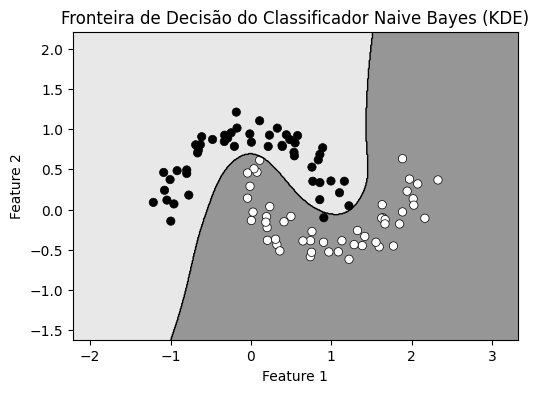

In [ ]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = KernelDensityNaiveBayes(bandwidth=0.25)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Acurácia do Classificador Naive Bayes (KDE): {accuracy * 100:.2f}%")

# Grade para fronteira de decisão
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="Greys", alpha=0.6)
ax.contour(xx, yy, Z, levels=[0], colors="black", linewidths=1.0)
shades = ((y + 1) // 2).astype(int)
ax.scatter(X[:, 0], X[:, 1], c=shades, cmap="gray", vmin=0, vmax=1, edgecolors="black", linewidths=0.5)
ax.set_title("Fronteira de Decisão do Classificador Naive Bayes (KDE)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_aspect("equal")
plt.show()



## Conjuntos de dados multivariados.

In [47]:
#Breast Cancer Wisconsin Dataset

import pandas as pd

df = pd.read_csv("C:\\Users\\felip\\Projetos Python\\Redes Neurais Mestrado\\DataSets\\Breast_Cancer.csv")
df.dropna(inplace=True)


In [48]:
df["Class"] = df["Class"].map({"malignant": -1, "benign": 1})


In [49]:
X, y = df.drop(columns=["Id", "Class","Unnamed: 0"]).values, df["Class"].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

selection_fraction = 0.3
bandwidth = 0.01

logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver="lbfgs"))
logreg.fit(X_train, y_train)
logreg_acc = float(logreg.score(X_test, y_test))

kde_nb = KernelDensityNaiveBayes(bandwidth=bandwidth)
kde_nb.fit(X_train, y_train)
kde_acc = float(kde_nb.score(X_test, y_test))

G_full = gg.GabrielGraph(device="cpu")
G_full.build(X_train, y_train)
y_pred_full = classify_by_nearest_support(G_full, X_test)
gabriel_full_acc = float(np.mean(y_pred_full == y_test))

log_probas_train = kde_nb.predict_log_proba(X_train)
uncertainty = np.abs(log_probas_train[:, 1] - log_probas_train[:, 0])
k = max(1, int(np.ceil(selection_fraction * len(X_train))))
selected_indices = np.argsort(uncertainty)[:k]

G_reduced = gg.GabrielGraph(device="cpu")
G_reduced.build(X_train[selected_indices], y_train[selected_indices])
y_pred_reduced = classify_by_nearest_support(G_reduced, X_test)
gabriel_reduced_acc = float(np.mean(y_pred_reduced == y_test))

support_vertices_info = _support_coverage(G_full, selected_indices)

support_edges_full = {tuple(sorted(edge)) for edge in G_full.support_edges() if G_full.y[edge[0]] != G_full.y[edge[1]]}
reduced_to_original = {int(i): int(idx) for i, idx in enumerate(selected_indices)}
support_edges_reduced = set()
for edge in G_reduced.support_edges():
    i, j = int(edge[0]), int(edge[1])
    if i in reduced_to_original and j in reduced_to_original:
        support_edges_reduced.add(tuple(sorted((reduced_to_original[i], reduced_to_original[j]))))
covered_edges = support_edges_full & support_edges_reduced
edge_coverage_pct = (
    100.0 * len(covered_edges) / len(support_edges_full) if support_edges_full else None
)

accuracy_df = pd.DataFrame(
    [
        {"Método": "Regressão Logística", "Acurácia": logreg_acc},
        {"Método": "Naive Bayes KDE", "Acurácia": kde_acc},
        {"Método": "Gabriel Completo", "Acurácia": gabriel_full_acc},
        {"Método": "Gabriel Reduzido", "Acurácia": gabriel_reduced_acc},
    ]
).sort_values("Acurácia", ascending=False).reset_index(drop=True)

coverage_df = pd.DataFrame(
    [
        {
            "Métrica": "Vértices de suporte",
            "Total": support_vertices_info["support_vertex_count"],
            "Cobertos": support_vertices_info["covered_support_vertices"],
            "Cobertura (%)": support_vertices_info["coverage_pct"],
        },
        {
            "Métrica": "Arestas de suporte",
            "Total": len(support_edges_full),
            "Cobertos": len(covered_edges),
            "Cobertura (%)": edge_coverage_pct,
        },
        {
            "Métrica": "Amostras selecionadas",
            "Total": len(X_train),
            "Cobertos": len(selected_indices),
            "Cobertura (%)": 100.0 * len(selected_indices) / len(X_train),
        },
    ]
)

display(accuracy_df)
display(coverage_df)

print("Acurácias médias por método e coberturas calculadas.")

,Método,Acurácia
0,Regressão Logística,0.956098
1,Gabriel Completo,0.946341
2,Naive Bayes KDE,0.941463
3,Gabriel Reduzido,0.878049


,Métrica,Total,Cobertos,Cobertura (%)
0,Vértices de suporte,167,54,32.335329
1,Arestas de suporte,370,86,23.243243
2,Amostras selecionadas,478,144,30.125523


Acurácias médias por método e coberturas calculadas.


In [60]:
#Iris Dataset

from sklearn.datasets import load_iris
mask = (y == 0) | (y == 1)

iris = load_iris()
X = iris.data
y = iris.target
X = X[mask]
y = y[mask]
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [61]:
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver="lbfgs"))
logreg.fit(X_train, y_train)
logreg_acc = float(logreg.score(X_test, y_test))

kde_nb = KernelDensityNaiveBayes(bandwidth=bandwidth)
kde_nb.fit(X_train, y_train)
kde_acc = float(kde_nb.score(X_test, y_test))

G_full = gg.GabrielGraph(device="cpu")
G_full.build(X_train, y_train)
y_pred_full = classify_by_nearest_support(G_full, X_test)
gabriel_full_acc = float(np.mean(y_pred_full == y_test))

log_probas_train = kde_nb.predict_log_proba(X_train)
uncertainty = np.abs(log_probas_train[:, 1] - log_probas_train[:, 0])
k = max(1, int(np.ceil(selection_fraction * len(X_train))))
selected_indices = np.argsort(uncertainty)[:k]

G_reduced = gg.GabrielGraph(device="cpu")
G_reduced.build(X_train[selected_indices], y_train[selected_indices])
y_pred_reduced = classify_by_nearest_support(G_reduced, X_test)
gabriel_reduced_acc = float(np.mean(y_pred_reduced == y_test))

support_vertices_info = _support_coverage(G_full, selected_indices)

support_edges_full = {tuple(sorted(edge)) for edge in G_full.support_edges() if G_full.y[edge[0]] != G_full.y[edge[1]]}
reduced_to_original = {int(i): int(idx) for i, idx in enumerate(selected_indices)}
support_edges_reduced = set()
for edge in G_reduced.support_edges():
    i, j = int(edge[0]), int(edge[1])
    if i in reduced_to_original and j in reduced_to_original:
        support_edges_reduced.add(tuple(sorted((reduced_to_original[i], reduced_to_original[j]))))
covered_edges = support_edges_full & support_edges_reduced
edge_coverage_pct = (
    100.0 * len(covered_edges) / len(support_edges_full) if support_edges_full else None
)

accuracy_df = pd.DataFrame(
    [
        {"Método": "Regressão Logística", "Acurácia": logreg_acc},
        {"Método": "Naive Bayes KDE", "Acurácia": kde_acc},
        {"Método": "Gabriel Completo", "Acurácia": gabriel_full_acc},
        {"Método": "Gabriel Reduzido", "Acurácia": gabriel_reduced_acc},
    ]
).sort_values("Acurácia", ascending=False).reset_index(drop=True)

coverage_df = pd.DataFrame(
    [
        {
            "Métrica": "Vértices de suporte",
            "Total": support_vertices_info["support_vertex_count"],
            "Cobertos": support_vertices_info["covered_support_vertices"],
            "Cobertura (%)": support_vertices_info["coverage_pct"],
        },
        {
            "Métrica": "Arestas de suporte",
            "Total": len(support_edges_full),
            "Cobertos": len(covered_edges),
            "Cobertura (%)": edge_coverage_pct,
        },
        {
            "Métrica": "Amostras selecionadas",
            "Total": len(X_train),
            "Cobertos": len(selected_indices),
            "Cobertura (%)": 100.0 * len(selected_indices) / len(X_train),
        },
    ]
)

display(accuracy_df)
display(coverage_df)

print("Acurácias médias por método e coberturas calculadas.")

,Método,Acurácia
0,Regressão Logística,1.0
1,Naive Bayes KDE,1.0
2,Gabriel Completo,1.0
3,Gabriel Reduzido,1.0


,Métrica,Total,Cobertos,Cobertura (%)
0,Vértices de suporte,3,3,100.0
1,Arestas de suporte,2,1,50.0
2,Amostras selecionadas,70,21,30.0


Acurácias médias por método e coberturas calculadas.


In [63]:
from sklearn.datasets import load_wine

#Wine Dataset
wine = load_wine()
X = wine.data
y = wine.target

mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
import json
from sklearn.datasets import load_iris, load_wine
import seaborn as sns

selection_fraction = 0.8
dataset_summaries = []
accuracy_tables = []
coverage_tables = []

def _evaluate_dataset(name, X, y, bandwidth):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
    )

    logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver="lbfgs"))
    logreg.fit(X_train, y_train)
    logreg_acc = float(logreg.score(X_test, y_test))

    kde_nb = KernelDensityNaiveBayes(bandwidth=bandwidth)
    kde_nb.fit(X_train, y_train)
    kde_acc = float(kde_nb.score(X_test, y_test))

    G_full = gg.GabrielGraph(device="cpu")
    G_full.build(X_train, y_train)
    y_pred_full = classify_by_nearest_support(G_full, X_test)
    gabriel_full_acc = float(np.mean(y_pred_full == y_test))

    log_probas_train = kde_nb.predict_log_proba(X_train)
    uncertainty = np.abs(log_probas_train[:, 1] - log_probas_train[:, 0])
    k = max(1, int(np.ceil(selection_fraction * len(X_train))))
    selected_indices = np.argsort(uncertainty)[:k]

    G_reduced = gg.GabrielGraph(device="cpu")
    G_reduced.build(X_train[selected_indices], y_train[selected_indices])
    y_pred_reduced = classify_by_nearest_support(G_reduced, X_test)
    gabriel_reduced_acc = float(np.mean(y_pred_reduced == y_test))

    support_vertices_info = _support_coverage(G_full, selected_indices)

    support_edges_full = {
        tuple(sorted(edge))
        for edge in G_full.support_edges()
        if G_full.y[edge[0]] != G_full.y[edge[1]]
    }
    reduced_to_original = {int(i): int(idx) for i, idx in enumerate(selected_indices)}
    support_edges_reduced = set()
    for edge in G_reduced.support_edges():
        i, j = int(edge[0]), int(edge[1])
        if i in reduced_to_original and j in reduced_to_original:
            support_edges_reduced.add(
                tuple(sorted((reduced_to_original[i], reduced_to_original[j])))
            )
    covered_edges = support_edges_full & support_edges_reduced
    edge_coverage_pct = (
        100.0 * len(covered_edges) / len(support_edges_full) if support_edges_full else None
    )

    accuracy_df = pd.DataFrame(
        [
            {"Método": "Regressão Logística", "Acurácia": logreg_acc},
            {"Método": "Naive Bayes KDE", "Acurácia": kde_acc},
            {"Método": "Gabriel Completo", "Acurácia": gabriel_full_acc},
            {"Método": "Gabriel Reduzido", "Acurácia": gabriel_reduced_acc},
        ]
    ).sort_values("Acurácia", ascending=False).reset_index(drop=True)

    coverage_df = pd.DataFrame(
        [
            {
                "Métrica": "Vértices de suporte",
                "Total": int(support_vertices_info["support_vertex_count"]),
                "Cobertos": int(support_vertices_info["covered_support_vertices"]),
                "Cobertura (%)": None
                if support_vertices_info["coverage_pct"] is None
                else float(support_vertices_info["coverage_pct"]),
            },
            {
                "Métrica": "Arestas de suporte",
                "Total": len(support_edges_full),
                "Cobertos": len(covered_edges),
                "Cobertura (%)": None if edge_coverage_pct is None else float(edge_coverage_pct),
            },
            {
                "Métrica": "Amostras selecionadas",
                "Total": len(X_train),
                "Cobertos": len(selected_indices),
                "Cobertura (%)": 100.0 * len(selected_indices) / len(X_train),
            },
        ]
    )

    summary = {
        "dataset": name,
        "bandwidth": float(bandwidth),
        "selection_fraction": float(selection_fraction),
        "accuracy": [
            {
                "metodo": row["Método"],
                "acuracia": float(row["Acurácia"]),
            }
            for _, row in accuracy_df.iterrows()
        ],
        "coverage": [
            {
                "metrica": row["Métrica"],
                "total": int(row["Total"]),
                "cobertos": int(row["Cobertos"]),
                "cobertura_pct": None
                if pd.isna(row["Cobertura (%)"])
                else float(row["Cobertura (%)"]),
            }
            for _, row in coverage_df.iterrows()
        ],
    }

    return summary, accuracy_df, coverage_df

# Breast Cancer dataset
df_bc = pd.read_csv(
    "C:/Users/felip/Projetos Python/Redes Neurais Mestrado/DataSets/Breast_Cancer.csv"
 )
df_bc.dropna(inplace=True)
df_bc["Class"] = df_bc["Class"].map({"malignant": -1, "benign": 1})
X_bc = df_bc.drop(columns=["Id", "Class", "Unnamed: 0"]).values
y_bc = df_bc["Class"].values

summary_bc, acc_bc, cov_bc = _evaluate_dataset(
    "Breast Cancer Wisconsin", X_bc, y_bc, bandwidth=0.01
 )
dataset_summaries.append(summary_bc)
acc_bc_display = acc_bc.copy()
acc_bc_display.insert(0, "Dataset", "Breast Cancer Wisconsin")
accuracy_tables.append(acc_bc_display)
cov_bc_display = cov_bc.copy()
cov_bc_display.insert(0, "Dataset", "Breast Cancer Wisconsin")
coverage_tables.append(cov_bc_display)

# Iris dataset (duas classes)
iris = load_iris()
mask_iris = (iris.target == 0) | (iris.target == 1)
X_iris = iris.data[mask_iris]
y_iris = iris.target[mask_iris]
y_iris = np.where(y_iris == 0, -1, 1)

summary_iris, acc_iris, cov_iris = _evaluate_dataset(
    "Iris (duas classes)", X_iris, y_iris, bandwidth=0.1
 )
dataset_summaries.append(summary_iris)
acc_iris_display = acc_iris.copy()
acc_iris_display.insert(0, "Dataset", "Iris (duas classes)")
accuracy_tables.append(acc_iris_display)
cov_iris_display = cov_iris.copy()
cov_iris_display.insert(0, "Dataset", "Iris (duas classes)")
coverage_tables.append(cov_iris_display)

# Wine dataset (duas classes)
wine = load_wine()
mask_wine = (wine.target == 0) | (wine.target == 1)
X_wine = wine.data[mask_wine]
y_wine = wine.target[mask_wine]
y_wine = np.where(y_wine == 0, -1, 1)

summary_wine, acc_wine, cov_wine = _evaluate_dataset(
    "Wine (duas classes)", X_wine, y_wine, bandwidth=0.1
 )
dataset_summaries.append(summary_wine)
acc_wine_display = acc_wine.copy()
acc_wine_display.insert(0, "Dataset", "Wine (duas classes)")
accuracy_tables.append(acc_wine_display)
cov_wine_display = cov_wine.copy()
cov_wine_display.insert(0, "Dataset", "Wine (duas classes)")
coverage_tables.append(cov_wine_display)

# Titanic dataset (variáveis numéricas)
titanic = sns.load_dataset("titanic")
titanic = titanic[["survived", "age", "sex", "pclass", "fare", "sibsp", "parch"]]
titanic_numeric = titanic.dropna()
titanic_numeric["sex"] = titanic_numeric["sex"].map({"male":    0, "female": 1})
#Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Scale all dataset except target
titanic_numeric.iloc[:, 1:] = scaler.fit_transform(titanic_numeric.iloc[:, 1:])


y_titanic = titanic_numeric["survived"].astype(int).values
X_titanic = titanic_numeric.drop(columns=["survived"]).values
y_titanic = np.where(y_titanic == 0, -1, 1)

summary_titanic, acc_titanic, cov_titanic = _evaluate_dataset(
    "Titanic (variáveis numéricas)", X_titanic, y_titanic, bandwidth=0.1
 )
dataset_summaries.append(summary_titanic)
acc_titanic_display = acc_titanic.copy()
acc_titanic_display.insert(0, "Dataset", "Titanic (variáveis numéricas)")
accuracy_tables.append(acc_titanic_display)
cov_titanic_display = cov_titanic.copy()
cov_titanic_display.insert(0, "Dataset", "Titanic (variáveis numéricas)")
coverage_tables.append(cov_titanic_display)

combined_accuracy_df = pd.concat(accuracy_tables, ignore_index=True)
combined_coverage_df = pd.concat(coverage_tables, ignore_index=True)

display(combined_accuracy_df)
display(combined_coverage_df)

summary_path = "resumo_multivariados.json"
with open(summary_path, "w", encoding="utf-8") as fp:
    json.dump(dataset_summaries, fp, ensure_ascii=False, indent=2)

print("Resumo geral salvo em", summary_path)

C:\Users\felip\AppData\Local\Temp\ipykernel_15376\3635277336.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_numeric["sex"] = titanic_numeric["sex"].map({"male":    0, "female": 1})
C:\Users\felip\AppData\Local\Temp\ipykernel_15376\3635277336.py:185: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.75905134  1.31743394  1.31743394  1.31743394 -0.75905134 -0.75905134
 -0.75905134  1.31743394  1.31743394  1.31743394  1.31743394 -0.75905134
 -0.75905134  1.31743394  1.31743394 -0.75905134  1.31743394 -0.75905134
 -0.75905134  1.31743394 -0.75905134  1.31743394  1.31743394 -0.75905134
 -0.75905134 -0.75905134 -0.75905134 -0.75905134 -0.75905134  1.31743394
  1.3174

,Dataset,Método,Acurácia
0,Breast Cancer Wisconsin,Gabriel Completo,0.970732
1,Breast Cancer Wisconsin,Regressão Logística,0.965854
2,Breast Cancer Wisconsin,Gabriel Reduzido,0.965854
3,Breast Cancer Wisconsin,Naive Bayes KDE,0.960976
4,Iris (duas classes),Regressão Logística,1.000000
5,Iris (duas classes),Naive Bayes KDE,1.000000
6,Iris (duas classes),Gabriel Completo,1.000000
7,Iris (duas classes),Gabriel Reduzido,1.000000
8,Wine (duas classes),Regressão Logística,0.974359
9,Wine (duas classes),Naive Bayes KDE,0.871795


,Dataset,Métrica,Total,Cobertos,Cobertura (%)
0,Breast Cancer Wisconsin,Vértices de suporte,158,113,71.518987
1,Breast Cancer Wisconsin,Arestas de suporte,351,278,79.202279
2,Breast Cancer Wisconsin,Amostras selecionadas,478,383,80.125523
3,Iris (duas classes),Vértices de suporte,3,3,100.000000
4,Iris (duas classes),Arestas de suporte,2,2,100.000000
5,Iris (duas classes),Amostras selecionadas,70,56,80.000000
6,Wine (duas classes),Vértices de suporte,18,18,100.000000
7,Wine (duas classes),Arestas de suporte,16,16,100.000000
8,Wine (duas classes),Amostras selecionadas,91,73,80.219780
9,Titanic (variáveis numéricas),Vértices de suporte,380,300,78.947368


Resumo geral salvo em resumo_multivariados.json


In [77]:
X = load_iris()